In [1]:
import numpy as np
from matplotlib import pyplot as plt
from urllib import request
import gzip
import pandas as pd
from os import path
from scipy.fft import fft, fftshift, fftfreq

In [2]:
week = 2310
day_of_week = 6

url = "https://sideshow.jpl.nasa.gov/pub/jpligsac/" + str(week) + "/"
filename = "jpl" + str(week) + str(day_of_week) + ".sp3.gz"
dpath = "jpligsac/"

# Download the file (if we don't have it already)
if not path.isfile(dpath + filename):
    downloaded_file, info = request.urlretrieve(
        url + filename,
        dpath + filename,
    )
    assert downloaded_file == dpath + filename

In [3]:
import csv

data = pd.read_csv(
    dpath + filename,
    skiprows=22,
    delimiter=" ",
    on_bad_lines="skip",
    comment="*",
    skipinitialspace=True,  # Interpret multiple spaces as 1 delimiter
    usecols=[i for i in range(4)],
    quoting=csv.QUOTE_NONE,
    names=(  # Optional: give meaningful names to each column of data file:
        "Clock",
        "x",
        "y",
        "z",
    ),
)[:-1]

In [4]:
print(data)

     Clock             x             y             z
0     PG02  -8343.086630  18552.120738 -16445.225740
1     PG03   5078.724000  18232.944248 -18836.084093
2     PG04  -1392.016614  26425.609729   1204.252471
3     PG05   9778.031478 -11482.937509  21692.607668
4     PG06  23924.308158  -3839.826129 -10945.134593
...    ...           ...           ...           ...
8954  PG28 -22643.346018   2031.343174 -13743.562846
8955  PG29  -4632.105087 -23873.829634  10491.048954
8956  PG30  20540.195004   3105.533259  16840.277129
8957  PG31 -24830.543909   9077.591987  -4449.355896
8958  PG32 -14423.653303  -7357.019440 -20878.956355

[8959 rows x 4 columns]


In [5]:
def convert_time(row):
    return np.sqrt(row["x"] ** 2 + row["y"] ** 2 + row["z"] ** 2)


# Apply this conversion to each row, store in new column "Time"
data["r"] = data.apply(convert_time, axis=1)

In [6]:
print(data)

     Clock             x             y             z             r
0     PG02  -8343.086630  18552.120738 -16445.225740  26157.861687
1     PG03   5078.724000  18232.944248 -18836.084093  26702.654501
2     PG04  -1392.016614  26425.609729   1204.252471  26489.635404
3     PG05   9778.031478 -11482.937509  21692.607668  26420.389491
4     PG06  23924.308158  -3839.826129 -10945.134593  26587.830991
...    ...           ...           ...           ...           ...
8954  PG28 -22643.346018   2031.343174 -13743.562846  26565.635578
8955  PG29  -4632.105087 -23873.829634  10491.048954  26485.434621
8956  PG30  20540.195004   3105.533259  16840.277129  26742.080723
8957  PG31 -24830.543909   9077.591987  -4449.355896  26809.613108
8958  PG32 -14423.653303  -7357.019440 -20878.956355  26421.550449

[8959 rows x 5 columns]


## Plot clock positions

['PG02' 'PG03' 'PG04' 'PG05' 'PG06' 'PG07' 'PG08' 'PG09' 'PG10' 'PG11'
 'PG12' 'PG13' 'PG14' 'PG15' 'PG16' 'PG17' 'PG18' 'PG19' 'PG20' 'PG21'
 'PG22' 'PG23' 'PG24' 'PG25' 'PG26' 'PG27' 'PG28' 'PG29' 'PG30' 'PG31'
 'PG32']


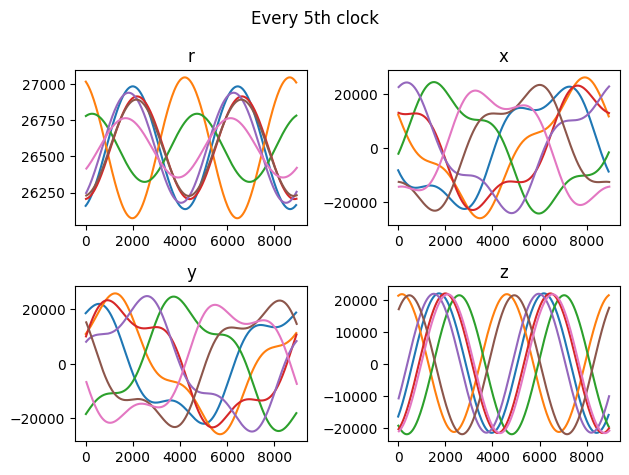

In [7]:
clock_list = np.sort(data["Clock"].unique())
print(clock_list)

fig, axs = plt.subplots(2, 2)
axs = axs.flatten()

N = 5
for i, clock in enumerate(clock_list):
    if i % N != 0:
        continue
    tdata = data[data["Clock"] == clock]
    axs[0].plot(tdata["r"], label=clock)
    axs[1].plot(tdata["x"])
    axs[2].plot(tdata["y"])
    axs[3].plot(tdata["z"])

axs[0].set_title("r")
axs[1].set_title("x")
axs[2].set_title("y")
axs[3].set_title("z")
fig.suptitle(f"Every {N}th clock")
fig.tight_layout()
plt.show()

## 3D plot

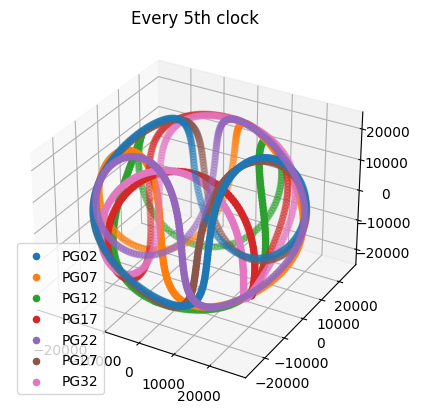

In [8]:
ax = plt.figure().add_subplot(projection="3d")

for i, clock in enumerate(clock_list):
    if i % N != 0:
        continue
    tdata = data[data["Clock"] == clock]
    ax.scatter(tdata["x"], tdata["y"], tdata["z"], label=clock)
plt.title(f"Every {N}th clock")
plt.legend()
plt.show()

## Plot the distance between each clock from the "best" clock (by noise)

* Highlight red if
    - (a) average distance is greater than 45,000 km, and 
    - (b) variation in distance is < 10%


General algorithm might be:
   - 1. Choose best clock (by standard deviation)
   - 2. Find all other clocks that match above condition
   - 3. Of these, choose the best (by standard deviation). This is pair 1
   - 4. Repeat above until we run out of good clocks!

Then, once we have a set of clocks pair for a given day, we can combine them into a weighted average.
Combining them should reduce the noise, but the signal will not cancel.

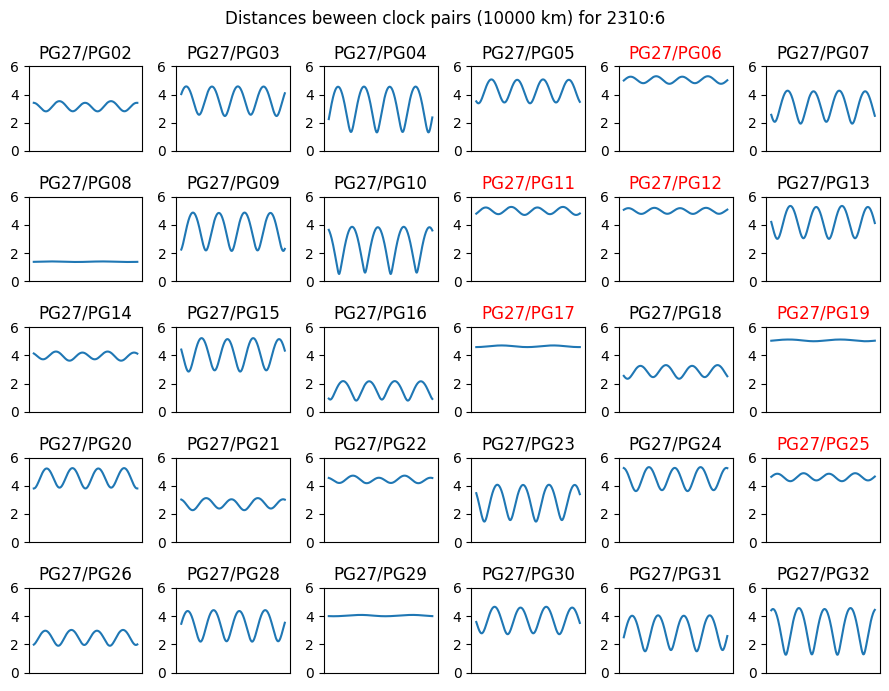

In [19]:
Nrow = 6
Ntot = len(clock_list)
Ncol = int((Ntot - 1) / Nrow)
fig, axs = plt.subplots(Ncol, Nrow, figsize=(9, 7))
axs = axs.flatten()


# clock1 = clock_list[0]
clock1 = "PG27"  # G27 is best clock this day
d1 = data[data["Clock"] == clock1]
count = 0
for clock2 in clock_list:
    if clock2 == clock1:
        continue
    d2 = data[data["Clock"] == clock2]
    dr = (
        np.sqrt(
            (d1["x"].to_numpy() - d2["x"].to_numpy()) ** 2
            + ((d1["y"].to_numpy() - d2["y"].to_numpy()) ** 2)
            + ((d1["z"].to_numpy() - d2["z"].to_numpy()) ** 2)
        )
        / 10000
    )
    good_pair = np.mean(dr) > 4.5 and np.std(dr) < 0.1 * np.mean(dr)
    axs[count].plot(dr)
    color = "red" if good_pair else "black"
    axs[count].set_title(f"{clock1}/{clock2}", color=color)
    axs[count].set_ylim(0, 6)
    axs[count].set_xticks([])
    count = count + 1


fig.suptitle(f"Distances beween clock pairs (10000 km) for {week}:{day_of_week}")
fig.tight_layout()
plt.show()

### ... second best clock

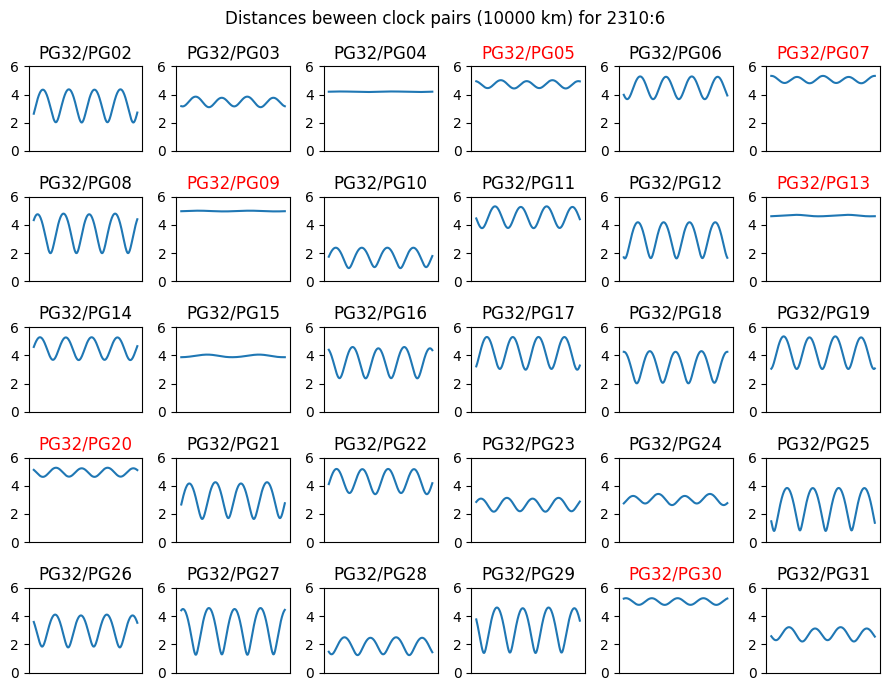

In [20]:
Nrow = 6
Ntot = len(clock_list)
Ncol = int((Ntot - 1) / Nrow)
fig, axs = plt.subplots(Ncol, Nrow, figsize=(9, 7))
axs = axs.flatten()


# clock1 = clock_list[0]
clock1 = "PG32"  # G32 is second best clock this day
d1 = data[data["Clock"] == clock1]
count = 0
for clock2 in clock_list:
    if clock2 == clock1:
        continue
    d2 = data[data["Clock"] == clock2]
    dr = (
        np.sqrt(
            (d1["x"].to_numpy() - d2["x"].to_numpy()) ** 2
            + ((d1["y"].to_numpy() - d2["y"].to_numpy()) ** 2)
            + ((d1["z"].to_numpy() - d2["z"].to_numpy()) ** 2)
        )
        / 10000
    )
    good_pair = np.mean(dr) > 4.5 and np.std(dr) < 0.1 * np.mean(dr)
    axs[count].plot(dr)
    color = "red" if good_pair else "black"
    axs[count].set_title(f"{clock1}/{clock2}", color=color)
    axs[count].set_ylim(0, 6)
    axs[count].set_xticks([])
    count = count + 1


fig.suptitle(f"Distances beween clock pairs (10000 km) for {week}:{day_of_week}")
fig.tight_layout()
plt.show()